In [ ]:
%pip install mido
%pip install numpy
%pip install pretty_midi
%pip install pandas
%pip install scikit-learn
%pip install faiss-cpu  # for similarity search

In [31]:
import os
from collections import Counter
import unittest
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pretty_midi
import faiss
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


NOTE: ipynb has different paths concept, use full path for ipynb

---

In [28]:
def extract_features(file_path):
    """
    Extract features from a MIDI file using a dictionary structure.
    Focuses on pitch, duration, rhythm, and tempo features.
    """
    try:
        midi_data = pretty_midi.PrettyMIDI(file_path)
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None
    
    # Initialize feature structure
    detailed_features = {
        'pitch_features': {'values': []},
        'duration_features': {'values': []},
        'rhythm_features': {
            'onset_times': [],
            'ioi_values': [],
            'beat_positions': [],
            'syncopation': []
        },
        'tempo': None,  # We'll set this below
        'time_signature': None,
        'key_signature': None
    }
    
    # Try to estimate tempo, fall back to initial tempo if that fails
    try:
        detailed_features['tempo'] = midi_data.estimate_tempo()
    except ValueError:
        # Get initial tempo from the MIDI file
        if len(midi_data.get_tempo_changes()) > 0:
            detailed_features['tempo'] = midi_data.get_tempo_changes()[1][0]
        else:
            detailed_features['tempo'] = 120.0  # Default fallback tempo
    
    # Extract time and key signatures
    for ts in midi_data.time_signature_changes:
        detailed_features['time_signature'] = f"{ts.numerator}/{ts.denominator}"
        break
        
    for ks in midi_data.key_signature_changes:
        detailed_features['key_signature'] = ks.key_number
        break

    # Collect note features and onset times
    for instrument in midi_data.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                detailed_features['pitch_features']['values'].append(note.pitch)
                detailed_features['duration_features']['values'].append(note.end - note.start)
                detailed_features['rhythm_features']['onset_times'].append(note.start)
    
    if not detailed_features['pitch_features']['values']:
        return None

    # Process rhythm features
    if len(detailed_features['rhythm_features']['onset_times']) > 0:
        onset_times = sorted(detailed_features['rhythm_features']['onset_times'])
        ioi_values = np.diff(onset_times)
        detailed_features['rhythm_features']['ioi_values'] = ioi_values.tolist()
        
        if detailed_features['time_signature']:
            beats_per_measure = int(detailed_features['time_signature'].split('/')[0])
            beat_duration = 60.0 / detailed_features['tempo']
            beat_positions = [t % (beats_per_measure * beat_duration) / beat_duration 
                            for t in onset_times]
            detailed_features['rhythm_features']['beat_positions'] = beat_positions
            
            syncopation = [1 if not np.isclose(pos % 1, 0, atol=0.1) else 0 
                          for pos in beat_positions]
            detailed_features['rhythm_features']['syncopation'] = syncopation

    # Calculate statistics
    for feature_type in ['pitch_features', 'duration_features']:
        values = np.array(detailed_features[feature_type]['values'])
        detailed_features[feature_type].update({
            'values': values.tolist(),
            'mean': float(np.mean(values)),
            'std': float(np.std(values)),
            'min': float(np.min(values)),
            'max': float(np.max(values))
        })
    
    # Add rhythm statistics
    if len(detailed_features['rhythm_features']['ioi_values']) > 0:
        ioi_values = np.array(detailed_features['rhythm_features']['ioi_values'])
        detailed_features['rhythm_features'].update({
            'ioi_mean': float(np.mean(ioi_values)),
            'ioi_std': float(np.std(ioi_values)),
            'syncopation_ratio': float(np.mean(detailed_features['rhythm_features']['syncopation']))
            if detailed_features['rhythm_features']['syncopation'] else 0.0
        })
    else:
        detailed_features['rhythm_features'].update({
            'ioi_mean': 0.0,
            'ioi_std': 0.0,
            'syncopation_ratio': 0.0
        })
    
    # Create simplified features for clustering
    simplified_features = {
        'tempo': float(detailed_features['tempo']),
        'pitch_mean': float(detailed_features['pitch_features']['mean']),
        'pitch_std': float(detailed_features['pitch_features']['std']),
        'duration_mean': float(detailed_features['duration_features']['mean']),
        'duration_std': float(detailed_features['duration_features']['std']),
        'ioi_mean': float(detailed_features['rhythm_features']['ioi_mean']),
        'ioi_std': float(detailed_features['rhythm_features']['ioi_std']),
        'syncopation_ratio': float(detailed_features['rhythm_features']['syncopation_ratio'])
    }
    
    return simplified_features

# Musical Feature Explanations

## Basic Features
- **tempo**: Speed of the music in beats per minute (BPM)
  - Example: 188.05 BPM = Very fast, energetic tempo
  - Range: Usually 60-200 BPM

## Pitch Features
- **pitch_mean**: Average MIDI note number (0-127)
  - Example: 50.37 ≈ D3 note
  - Range: 0 (lowest) to 127 (highest)
  - Reference: Middle C (C4) = 60

- **pitch_std**: How spread out the notes are from the mean
  - Example: 7.31 = Notes span about 1 octave
  - Higher value = More melodic variation

## Timing Features
- **duration_mean**: Average note length in seconds
  - Example: 0.22s = Mostly short notes
  - Lower values = Faster, staccato notes
  - Higher values = Longer, sustained notes

- **duration_std**: Variation in note lengths
  - Example: 0.07s = Fairly consistent note lengths
  - Higher value = More rhythmic variety

## Rhythm Features
- **ioi_mean**: Average time between note onsets (Inter-Onset Interval)
  - Example: 1.84s = Relatively sparse notes
  - Lower values = Notes close together
  - Higher values = More space between notes

- **ioi_std**: Variation in timing between notes
  - Example: 14.67 = Very irregular rhythm
  - Higher value = More rhythmic complexity

- **syncopation_ratio**: Proportion of notes that fall between beats
  - Example: 0.96 = Almost all notes are syncopated
  - Range: 0 (on-beat) to 1 (all syncopated)
  - Higher value = More rhythmic tension

---

### Similarity Search Index
FAISS for efficient similarity searches in high-dimensional spaces

FAISS -- Facebook AI Similarity Search (https://ai.meta.com/tools/faiss/)

# TODO: check what happens if inside a midi there is only one note

In [3]:
def build_faiss_index(feature_list):
    """
    - Fit a StandardScaler on feature_list
    - Scale the data
    - Build a FAISS IndexFlatL2
    Returns (faiss_index, scaler, scaled_features).
    """
    # Convert list to numpy array
    feature_matrix = np.array(feature_list, dtype='float32')
    
    # Fit scaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_matrix)
    
    # Build FAISS index
    d = scaled_features.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(scaled_features)
    
    return index, scaler, scaled_features


In [4]:
def find_similar_midi(query_file_path, file_names, faiss_index, scaler, k=5):
    """
    Given a query MIDI file and a FAISS index, returns top-k similar files.
    """
    query_feats = extract_features(query_file_path)
    if query_feats is None:
        print("Failed to extract features from query file.")
        return [], []
    
    query_vector = np.array([
        query_feats['tempo'],
        query_feats['pitch_mean'],
        query_feats['pitch_std'],
        query_feats['duration_mean'],
        query_feats['duration_std'],
        query_feats['ioi_mean'],
        query_feats['ioi_std'],
        query_feats['syncopation_ratio']
    ], dtype='float32').reshape(1, -1)
    
    # Scale the query with the same scaler
    query_scaled = scaler.transform(query_vector)
    
    # Search top-k
    distances, indices = faiss_index.search(query_scaled.astype('float32'), k)
    
    # Retrieve file names and distances
    results_files = [file_names[i] for i in indices[0]]
    results_distances = distances[0]
    
    return results_files, results_distances


In [5]:
def process_dataset(dataset_folder):
    """
    Extract features from all MIDI files within a folder structure.
    Returns (feature_list, file_names).
    """
    feature_list = []
    file_names = []
    
    for root, _, files in os.walk(dataset_folder):
        for file in files:
            if file.lower().endswith(('.mid', '.midi')):
                midi_path = os.path.join(root, file)
                feats = extract_features(midi_path)
                if feats is not None:
                    feature_vec = [
                        feats['tempo'],
                        feats['pitch_mean'],
                        feats['pitch_std'],
                        feats['duration_mean'],
                        feats['duration_std'],
                        feats['ioi_mean'],
                        feats['ioi_std'],
                        feats['syncopation_ratio']
                    ]
                    feature_list.append(feature_vec)
                    file_names.append(midi_path)
    
    if not feature_list:
        raise ValueError("No valid MIDI files found in the dataset folder.")
    
    return feature_list, file_names


In [ ]:
if __name__ == "__main__": # EXAMPLE USAGE
    # Suppose we have a dataset folder
    dataset_path = "/path/to/your/midi/dataset"
    
    # Process dataset -> (feature_list, file_names)
    feature_list, file_names = process_dataset(dataset_path)
    
    # Build FAISS index
    faiss_index, scaler, _ = build_faiss_index(feature_list)
    
    # Query
    query_midi_path = "/path/to/query/file.mid"
    k_neighbors = 5
    
    similar_files, dists = find_similar_midi(query_midi_path, file_names, faiss_index, scaler, k=k_neighbors)
    
    print(f"\nQuery: {query_midi_path}")
    print(f"Top {k_neighbors} similar files:")
    for fpath, dist in zip(similar_files, dists):
        # Optionally convert distance -> similarity ( e.g. 1/(1+dist) )
        sim = 1.0 / (1.0 + dist)
        print(f"\tFile: {fpath} | Distance: {dist:.4f} | Similarity: {sim:.2%}")


#### this is the main carcass of the program backend, let's do unit testing with "synthetic" midi's  

---

In [17]:
def create_synthetic_midi(file_path, tempo=120, pitch=60, duration=1.0, velocity=100):
    """
    Creates a simple MIDI file at `file_path` with at least TWO notes:
        - A PrettyMIDI object with an initial tempo
        - One instrument (non-drum)
        - Note #1: pitch, duration, velocity starting at t=0
        - Note #2: pitched slightly higher (pitch+2) and starts after note #1
    """
    # Initialize the PrettyMIDI object with the chosen tempo
    midi_data = pretty_midi.PrettyMIDI(initial_tempo=tempo)
    
    # Create an Instrument (program=0 -> Acoustic Grand Piano)
    instrument = pretty_midi.Instrument(program=0, is_drum=False)
    
    # --- Note #1 ---
    start_time_1 = 0.0
    end_time_1 = start_time_1 + duration
    note1 = pretty_midi.Note(
        velocity=int(velocity),
        pitch=pitch,
        start=start_time_1,
        end=end_time_1
    )
    instrument.notes.append(note1)
    
    # --- Note #2 ---
    # Make it start a bit after note #1 ends
    start_time_2 = end_time_1 + 0.5
    end_time_2 = start_time_2 + duration
    note2 = pretty_midi.Note(
        velocity=int(velocity),
        pitch=pitch + 2,   # Slightly higher pitch
        start=start_time_2,
        end=end_time_2
    )
    instrument.notes.append(note2)
    
    # Add the instrument to the MIDI object
    midi_data.instruments.append(instrument)

    # Write the final MIDI to file
    midi_data.write(file_path)


In [18]:
output_folder = "toy--synthetic-midis"
os.makedirs(output_folder, exist_ok=True)


In [19]:
# SYNTHETIC Group A: tempo=120, pitch=60..69
for i in range(10):
    pitch_value = 60 + i
    filename = f"GroupA_tempo120_pitch{pitch_value}.mid"
    file_path = os.path.join(output_folder, filename)
    create_synthetic_midi(file_path, tempo=120, pitch=pitch_value, duration=1.0, velocity=100)


In [20]:
# SYNTHETIC Group B: tempo=90, pitch=50..59
for i in range(10):
    pitch_value = 50 + i
    filename = f"GroupB_tempo90_pitch{pitch_value}.mid"
    file_path = os.path.join(output_folder, filename)
    create_synthetic_midi(file_path, tempo=90, pitch=pitch_value, duration=1.0, velocity=100)


In [21]:
class TestMidiSimilarityNotebook(unittest.TestCase):

    def test_process_dataset(self):
        """
        Test that process_dataset can parse a known folder of synthetic MIDI files
        and return the correct number of vectors + file names.
        """
        dataset_folder = "/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/testing_tools/clustering/toy--synthetic-midis"  # adapt path if needed
        feature_list, file_names = process_dataset(dataset_folder)
        
        # Check we have at least 20 MIDI files
        self.assertGreaterEqual(len(feature_list), 20, 
            "Should have at least 20 valid MIDI feature vectors.")
        self.assertGreaterEqual(len(file_names), 20, 
            "Should have at least 20 valid MIDI file names.")

        # Each vector should be 8D (tempo, pitch_mean, pitch_std, duration_mean, duration_std, ioi_mean, ioi_std, syncopation_ratio)
        arr = np.array(feature_list)
        self.assertEqual(arr.shape[1], 8, "Feature vectors should have size 8.")

    def test_build_index(self):
        """
        Test that we can build a FAISS index from the synthetic dataset.
        """
        dataset_folder = "toy--synthetic-midis"
        feature_list, file_names = process_dataset(dataset_folder)
        
        faiss_index, scaler, scaled_features = build_faiss_index(feature_list)
        
        # The index should contain as many vectors as we have files
        self.assertEqual(faiss_index.ntotal, len(file_names),
            "FAISS index should contain the same number of vectors as files processed.")
        
        # Check scaling shape is correct
        self.assertEqual(scaled_features.shape, (len(file_names), 8),
            "Scaled feature matrix should match the number of files x 8 features.")

    def test_find_similar_midi(self):
        """
        Test that find_similar_midi can locate the top-k similar files for a known query.
        """
        dataset_folder = "toy--synthetic-midis"
        feature_list, file_names = process_dataset(dataset_folder)
        faiss_index, scaler, scaled_features = build_faiss_index(feature_list)

        # Let's pick one file from the synthetic set as a query
        # e.g., the first file in the returned list
        if file_names:
            query_file = file_names[0]
            top_k = 5
            similar_files, dists = find_similar_midi(query_file, file_names, faiss_index, scaler, k=top_k)
            
            # Basic checks
            self.assertEqual(len(similar_files), top_k, "Should return k similar files.")
            self.assertEqual(len(dists), top_k, "Should return k distances.")
            
            # The most similar file to itself should be the file itself (distance ~ 0)
            self.assertEqual(similar_files[0], query_file,
                "The top match for a file should be itself, with distance near zero.")
        else:
            self.skipTest("No files found in dataset to test similarity search.")



In [22]:
# run tests 
suite = unittest.TestLoader().loadTestsFromTestCase(TestMidiSimilarityNotebook)
unittest.TextTestRunner(verbosity=2).run(suite)


test_build_index (__main__.TestMidiSimilarityNotebook.test_build_index)
Test that we can build a FAISS index from the synthetic dataset. ... ok
test_find_similar_midi (__main__.TestMidiSimilarityNotebook.test_find_similar_midi)
Test that find_similar_midi can locate the top-k similar files for a known query. ... ok
test_process_dataset (__main__.TestMidiSimilarityNotebook.test_process_dataset)
Test that process_dataset can parse a known folder of synthetic MIDI files ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.088s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

let's create more synthetic midi, longer ones

In [23]:
def create_diverse_midi_with_name(
    group_label,       # "GroupC", "GroupD", etc.
    index,             # 1..10
    output_folder,     
    tempo_min, 
    tempo_max,
    pitch_min, 
    pitch_max,
    min_notes, 
    max_notes,
    min_duration=0.2, 
    max_duration=2.0, 
    min_velocity=40, 
    max_velocity=100
):
    """
    Creates a MIDI file with random features, then names the file based on:
      - group_label: "GroupC", "GroupD", "GroupE", "GroupF"
      - index: file index within the group
      - final chosen tempo
      - average pitch of all notes

    The file is placed in output_folder with a name like:
      "GroupC_1_tempo65_avgPitch53.mid"
    """

    # 1) Random tempo
    tempo = random.uniform(tempo_min, tempo_max)
    midi_data = pretty_midi.PrettyMIDI(initial_tempo=tempo)

    # 2) Create an Instrument
    instrument = pretty_midi.Instrument(program=0, is_drum=False)

    # 3) Decide how many notes to place
    n_notes = random.randint(min_notes, max_notes)
    
    current_time = 0.0
    pitches_used = []  # to track pitches for an average

    for _ in range(n_notes):
        # Random pitch
        pitch_val = random.randint(pitch_min, pitch_max)
        pitches_used.append(pitch_val)
        
        # Random note duration
        note_duration = random.uniform(min_duration, max_duration)
        
        # Random velocity
        velocity = random.randint(min_velocity, max_velocity)
        
        # Random gap before next note
        gap = random.uniform(0.1, 1.0)
        start_time = current_time + gap
        end_time = start_time + note_duration
        
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=pitch_val,
            start=start_time,
            end=end_time
        )
        instrument.notes.append(note)
        
        current_time = end_time
    
    midi_data.instruments.append(instrument)

    # 4) Compute average pitch
    if pitches_used:
        avg_pitch = sum(pitches_used)/len(pitches_used)
    else:
        avg_pitch = 60.0  # fallback if no notes

    rounded_tempo = int(round(tempo))
    rounded_pitch = int(round(avg_pitch))

    # 5) Construct file name with group, index, tempo, avg pitch
    file_name = f"{group_label}_{index}_tempo{rounded_tempo}_avgPitch{rounded_pitch}.mid"
    file_path = os.path.join(output_folder, file_name)

    # 6) Write MIDI to disk
    midi_data.write(file_path)

def generate_synthetic_dataset_by_groups_CDEF(output_folder="toy--synthetic-midis"):
    """
    Creates 4 new groups (C, D, E, F), each with 10 MIDI files.
    Each group has distinct tempo + pitch ranges, and final names embed
    the chosen tempo & average pitch for easy reference.
    """
    os.makedirs(output_folder, exist_ok=True)
    
    # Group C: slow tempo, lower pitch
    #   tempo 60-70, pitch 50-57, 2-4 notes
    for i in range(1, 11):
        create_diverse_midi_with_name(
            group_label="GroupC",
            index=i,
            output_folder=output_folder,
            tempo_min=60, tempo_max=70,
            pitch_min=50, pitch_max=57,
            min_notes=2, max_notes=4
        )
    
    # Group D: moderate tempo, mid pitch
    #   tempo 80-90, pitch 58-65, 3-5 notes
    for i in range(1, 11):
        create_diverse_midi_with_name(
            group_label="GroupD",
            index=i,
            output_folder=output_folder,
            tempo_min=80, tempo_max=90,
            pitch_min=58, pitch_max=65,
            min_notes=3, max_notes=5
        )

    # Group E: medium-fast tempo, higher mid pitch
    #   tempo 100-110, pitch 66-73, 4-6 notes
    for i in range(1, 11):
        create_diverse_midi_with_name(
            group_label="GroupE",
            index=i,
            output_folder=output_folder,
            tempo_min=100, tempo_max=110,
            pitch_min=66, pitch_max=73,
            min_notes=4, max_notes=6
        )
    
    # Group F: fast tempo, high pitch
    #   tempo 120-130, pitch 74-81, 5-8 notes
    for i in range(1, 11):
        create_diverse_midi_with_name(
            group_label="GroupF",
            index=i,
            output_folder=output_folder,
            tempo_min=120, tempo_max=130,
            pitch_min=74, pitch_max=81,
            min_notes=5, max_notes=8
        )

    print(f"\nCreated 40 synthetic MIDIs in '{output_folder}':")
    print(" - GroupC: 10 files  (tempo ~60-70, pitch 50-57, 2-4 notes)")
    print(" - GroupD: 10 files  (tempo ~80-90, pitch 58-65, 3-5 notes)")
    print(" - GroupE: 10 files  (tempo ~100-110, pitch 66-73, 4-6 notes)")
    print(" - GroupF: 10 files  (tempo ~120-130, pitch 74-81, 5-8 notes)")
    print("\nFile names look like: 'GroupC_1_tempo65_avgPitch53.mid' etc.")


In [24]:
generate_synthetic_dataset_by_groups_CDEF("toy--synthetic-midis")


Created 40 synthetic MIDIs in 'toy--synthetic-midis':
 - GroupC: 10 files  (tempo ~60-70, pitch 50-57, 2-4 notes)
 - GroupD: 10 files  (tempo ~80-90, pitch 58-65, 3-5 notes)
 - GroupE: 10 files  (tempo ~100-110, pitch 66-73, 4-6 notes)
 - GroupF: 10 files  (tempo ~120-130, pitch 74-81, 5-8 notes)

File names look like: 'GroupC_1_tempo65_avgPitch53.mid' etc.


In [39]:
class TestRandomQueriesInSyntheticFolder(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        """
        Runs once before all tests. We'll build the FAISS index for the entire folder 
        so we don't have to do it for each individual test.
        """
        cls.dataset_folder = "/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/testing_tools/clustering/toy--synthetic-midis"  # Adjust path if needed
        
        # Process the synthetic folder: extract features
        cls.feature_list, cls.file_names = process_dataset(cls.dataset_folder)
        
        # Build the FAISS index
        cls.faiss_index, cls.scaler, cls.scaled_features = build_faiss_index(cls.feature_list)

        if len(cls.file_names) == 0:
            raise ValueError("No files found in synthetic dataset! Can't run tests.")
        
        print(f"setUpClass: Loaded {len(cls.file_names)} MIDI files.")
    
    def test_random_queries(self):
        """
        Tests the similarity search functionality by selecting random MIDI files and verifying
        that their nearest neighbors belong to the same group (e.g., GroupA, GroupB, etc.).
        """
        # Select 5 random files for testing
        num_random_queries = 5
        chosen_files = random.sample(self.file_names, min(num_random_queries, len(self.file_names)))

        # Find k nearest neighbors for each query
        k = 5
        for query_file in chosen_files:
            query_basename = os.path.basename(query_file)
            
            # Extract group identifier (e.g., "GroupA" from "GroupA_tempo120_pitch63.mid")
            query_group = query_basename.split('_')[0]

            # Find similar MIDI files using FAISS index
            similar_files, dists = find_similar_midi(query_file, self.file_names, 
                                                     self.faiss_index, self.scaler, k=k)

            # Count matches from the same group
            same_group_count = 0
            for f in similar_files:
                f_group = os.path.basename(f).split('_')[0]
                if f_group == query_group:
                    same_group_count += 1
            
            # Print results for debugging
            print(f"\nQuery: {query_basename}")
            print(f"Top {k} neighbors:")
            for fpath, dist in zip(similar_files, dists):
                print(f"  {os.path.basename(fpath)} [dist={dist:.4f}]")

            # Assert that at least 3 out of 5 neighbors are from the same group
            self.assertTrue(same_group_count >= 3,
                            f"We expect at least 3 out of {k} neighbors to share the same group. "
                            f"Found only {same_group_count} for query '{query_basename}'.")

        # If all random queries pass, we're good!
    

In [40]:
suite = unittest.TestLoader().loadTestsFromTestCase(TestRandomQueriesInSyntheticFolder)
unittest.TextTestRunner(verbosity=2).run(suite) # run the tests

test_random_queries (__main__.TestRandomQueriesInSyntheticFolder.test_random_queries)
Tests the similarity search functionality by selecting random MIDI files and verifying ... ok

----------------------------------------------------------------------
Ran 1 test in 0.100s

OK


setUpClass: Loaded 60 MIDI files.

Query: GroupF_2_tempo128_avgPitch76.mid
Top 5 neighbors:
  GroupF_2_tempo128_avgPitch76.mid [dist=0.0000]
  GroupF_9_tempo127_avgPitch77.mid [dist=1.4302]
  GroupF_7_tempo124_avgPitch79.mid [dist=2.6650]
  GroupE_2_tempo107_avgPitch70.mid [dist=3.6245]
  GroupF_6_tempo128_avgPitch78.mid [dist=6.4154]

Query: GroupB_tempo90_pitch59.mid
Top 5 neighbors:
  GroupB_tempo90_pitch59.mid [dist=0.0000]
  GroupA_tempo120_pitch60.mid [dist=0.0143]
  GroupB_tempo90_pitch58.mid [dist=0.0143]
  GroupA_tempo120_pitch61.mid [dist=0.0570]
  GroupB_tempo90_pitch57.mid [dist=0.0570]

Query: GroupB_tempo90_pitch51.mid
Top 5 neighbors:
  GroupB_tempo90_pitch51.mid [dist=0.0000]
  GroupB_tempo90_pitch50.mid [dist=0.0143]
  GroupB_tempo90_pitch52.mid [dist=0.0143]
  GroupB_tempo90_pitch53.mid [dist=0.0570]
  GroupB_tempo90_pitch54.mid [dist=0.1283]

Query: GroupC_3_tempo62_avgPitch54.mid
Top 5 neighbors:
  GroupC_3_tempo62_avgPitch54.mid [dist=0.0000]
  GroupC_6_tempo64_avg

<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## this happens becaus of pitch variance most probably

In [35]:
def visualize_midi_tsne(folder_path="toy--synthetic-midis"):
    """
    1) Loads feature vectors + file names from 'folder_path' using process_dataset()
    2) Scales the data
    3) Applies t-SNE to reduce to 2D
    4) Plots each MIDI as a scatter point, colored by group label (parsed from filename)
    5) Annotates each point with the MIDI file name.
    """
    # 1. Load dataset
    feature_list, file_names = process_dataset(folder_path)
    feature_matrix = np.array(feature_list, dtype=np.float32)

    # 2. Scale the data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_matrix)

    # 3. Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    tsne_result = tsne.fit_transform(scaled_features)

    # 4. Detect group labels by parsing file names
    #    E.g., "GroupC_2_tempo65_avgPitch53.mid" -> "GroupC"
    groups = []
    for f in file_names:
        base = os.path.basename(f)
        group_label = base.split('_')[0] 
        groups.append(group_label)

    # Collect unique groups
    unique_groups = sorted(list(set(groups)))

    # Assign each group a color
    color_map = {
        "GroupA": "black",
        "GroupB": "red",
        "GroupC": "blue",
        "GroupD": "green",
        "GroupE": "orange",
        "GroupF": "purple",
        # add more if needed, or fallback to a colormap if many
    }

    # 5. Plot
    plt.figure(figsize=(10, 8))
    for idx, (x, y) in enumerate(tsne_result):
        grp = groups[idx]
        # Pick color from dictionary or default
        c = color_map.get(grp, "gray")  
        plt.scatter(x, y, color=c, alpha=0.7, s=50)

    # Optionally add text labels for each point (could cause clutter if large set):
    for idx, (x, y) in enumerate(tsne_result):
        filename = os.path.basename(file_names[idx])
        plt.text(x+0.2, y, filename, fontsize=8)

    # Make a legend (only for known groups in color_map)
    for g, col in color_map.items():
        if g in unique_groups:
            plt.scatter([], [], color=col, label=g)  # dummy points for legend
    plt.legend(title="Groups")
    
    plt.title("t-SNE Visualization of MIDI Feature Space")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True, alpha=0.3)
    plt.show()
        

/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/myenv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


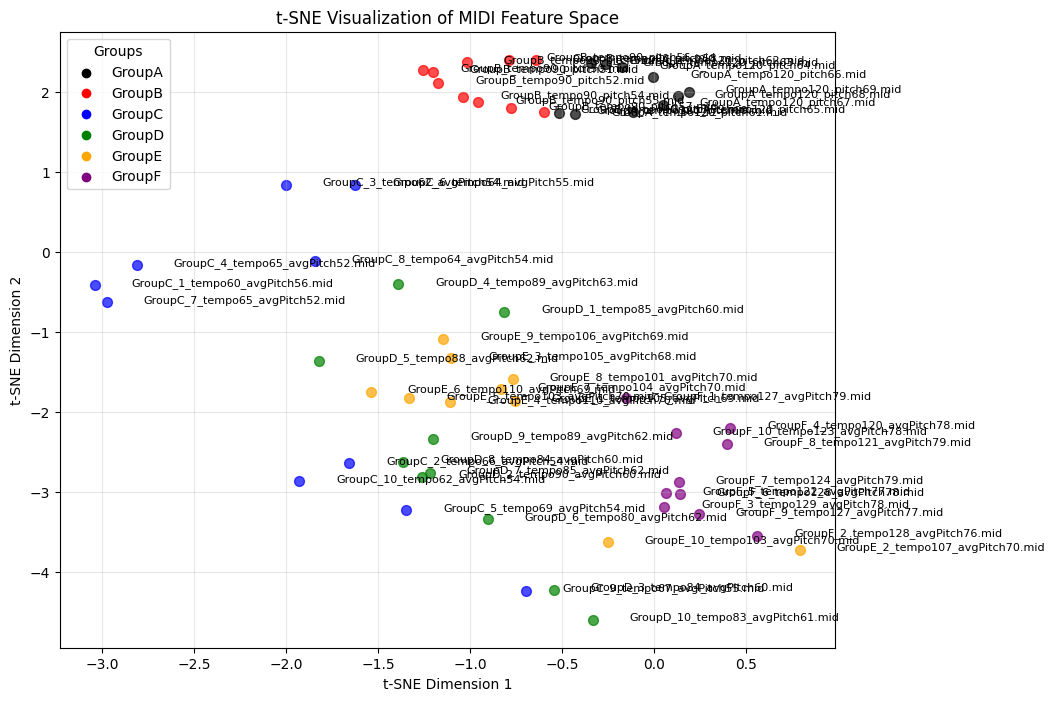

In [36]:
visualize_midi_tsne("toy--synthetic-midis")


In [37]:
def demo_similarity_search(dataset_folder="toy--synthetic-midis", k=3):
    """
    1) Process the dataset to extract features from all .mid files
    2) Build a FAISS index
    3) For each MIDI file in the dataset:
        - Print the file name
        - Find top-k nearest neighbors
        - Print them (along with distances or similarity)
    """

    # 1. Process dataset (extract_features + unify into feature_list, file_names)
    feature_list, file_names = process_dataset(dataset_folder)

    # 2. Build the FAISS index
    faiss_index, scaler, scaled_features = build_faiss_index(feature_list)

    # 3. For each file in file_names
    for idx, midi_file in enumerate(file_names):
        print(f"\n=== Query {idx+1}/{len(file_names)} ===")
        print(f"Query File: {os.path.basename(midi_file)}")

        # Use find_similar_midi function to get top k matches
        similar_files, distances = find_similar_midi(
            midi_file, file_names, faiss_index, scaler, k=k
        )

        # Print them
        print(f"Top {k} similar files:")
        for fpath, dist in zip(similar_files, distances):
            # Optionally compute a "similarity" measure
            similarity = 1.0 / (1.0 + dist)
            print(f"  - {os.path.basename(fpath)} (dist={dist:.4f}, sim={similarity:.2%})")


In [38]:
demo_similarity_search("toy--synthetic-midis", k=3)


=== Query 1/60 ===
Query File: GroupD_10_tempo83_avgPitch61.mid
Top 3 similar files:
  - GroupD_10_tempo83_avgPitch61.mid (dist=0.0000, sim=100.00%)
  - GroupD_3_tempo84_avgPitch60.mid (dist=10.0641, sim=9.04%)
  - GroupD_6_tempo80_avgPitch62.mid (dist=12.4410, sim=7.44%)

=== Query 2/60 ===
Query File: GroupE_9_tempo106_avgPitch69.mid
Top 3 similar files:
  - GroupE_9_tempo106_avgPitch69.mid (dist=0.0000, sim=100.00%)
  - GroupE_3_tempo105_avgPitch68.mid (dist=1.3397, sim=42.74%)
  - GroupE_7_tempo104_avgPitch70.mid (dist=2.6403, sim=27.47%)

=== Query 3/60 ===
Query File: GroupE_1_tempo105_avgPitch69.mid
Top 3 similar files:
  - GroupE_1_tempo105_avgPitch69.mid (dist=0.0000, sim=100.00%)
  - GroupE_8_tempo101_avgPitch70.mid (dist=1.4793, sim=40.33%)
  - GroupE_7_tempo104_avgPitch70.mid (dist=1.5590, sim=39.08%)

=== Query 4/60 ===
Query File: GroupB_tempo90_pitch59.mid
Top 3 similar files:
  - GroupB_tempo90_pitch59.mid (dist=0.0000, sim=100.00%)
  - GroupA_tempo120_pitch60.mid (dis